The goal of this notebook is the tell the story about the MPC. The MPC consists of 2 mains things. An internal wind farm model (using PyWake), and an optimizer (Dual annealing). 

In [2]:
from mpcrl.mpc import *
import numpy as np
from py_wake.examples.data.hornsrev1 import V80
import matplotlib.pyplot as plt

In [28]:
x_pos = np.array([0, 500, 900])
y_pos = np.array([0, 0, 0])
D = 80
APPLY_YAW_PENALTY = False

In [29]:
# We can setup the MPC model like this
mpc_model = WindFarmModel(x_pos, y_pos, D=D, cache_size=64000, 
                          wt=V80(),
                            cache_quant=0.25, wind_quant=0.25,
                            apply_yaw_penalty=APPLY_YAW_PENALTY)

In [30]:
#The mpc_model has a pywake farm internally:
mpc_model.wfm

In [31]:
# It also uses internal values for the wind conditions: 
mpc_model.U_inf, mpc_model.wd, mpc_model.TI

(8.0, 270.0, 0.06)

In [32]:
# It also sorts the wind turbines from front to back
mpc_model.sorted_indices

array([0, 1, 2])

In [86]:
# This calculates the power, given a set of yaw angles
mpc_model.farm_power(np.array([-10, 10, 10])).round()

array([667317., 136640., 229229.])

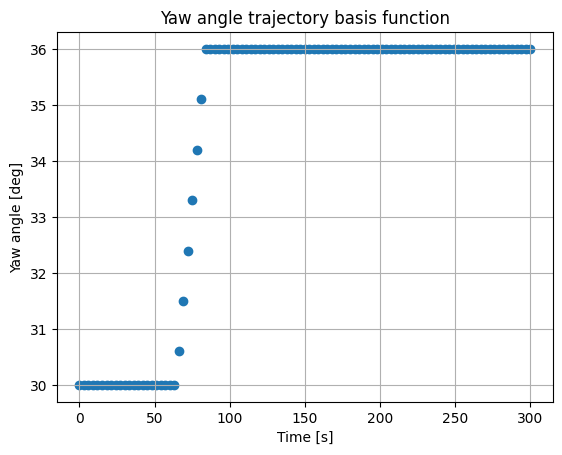

In [88]:
# The yaw angles follow a 'basis function'. We can see this by calling the yaw_traj function

t, gamma = yaw_traj(gamma0=30,       # Inital yaw angle
                    o1=0.6,         # values used for the basis function 
                    o2=0.8,         # values used for the basis function
                    t_AH=100,       # Time at which the action ends.
                    r_gamma=0.3,    # Rate of change of yaw angle [deg/s]
                    dt=3,           # The time step. 
                    T_total=300)    # Total time

plt.scatter(t, gamma)
plt.xlabel('Time [s]')
plt.ylabel('Yaw angle [deg]')
plt.title('Yaw angle trajectory basis function')
plt.grid()
plt.show()


In [89]:
# Yaw params is a list of [o1, o2] for each wind turbine
yaw_params = [[0.2, 0.5],
              [0.1, 0.7],
              [0.3, 0.4]]

In [94]:
# We can then use the delayed farm calculater, to get power values of the farm, over time.
t, traj, P = run_farm_delay_loop_optimized(model=mpc_model,
                              yaw_params=yaw_params,
                              current_yaw_angles_sorted=np.array([0, 0, 0]),
                              r_gamma=0.3,
                              t_AH=100,
                              dt = 10,
                              T=300
                              )

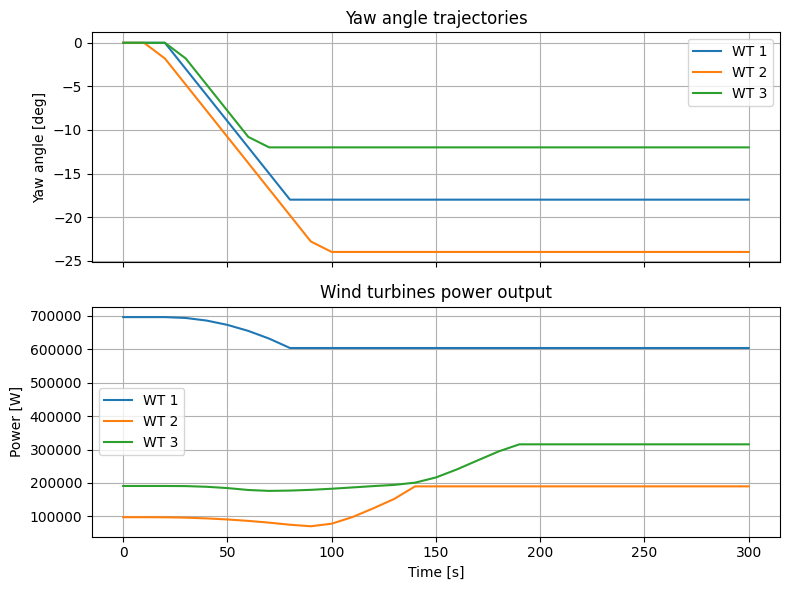

In [95]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

for i, tra in enumerate(traj):
    axs[0].plot(t, tra, label=f'WT {i+1}')

for i, power in enumerate(P):
    axs[1].plot(t, power, label=f'WT {i+1}')

axs[0].set_ylabel('Yaw angle [deg]')
axs[0].set_title('Yaw angle trajectories')
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Power [W]')
axs[1].set_title('Wind turbines power output')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


The way that it works is that is simply uses the yaws that the turbines had, but at a delayed time step. See the delay matrix here:

In [96]:
mpc_model.delays

array([[  0. ,  62.5, 112.5],
       [  0. ,   0. ,  50. ],
       [  0. ,   0. ,   0. ]])

The final piece is the optimize_farm_back2front.

It basically goes from the back to the front, and optimizes the power of the farm. 

It uses the run_farm_delay_loop_optimized function, but only varies the o1, o2 parameters, for the turbine currently being optimized. 

Note that it can either use 'just' the farm power, or it can implement work with the version using the time shifted approach. 


In [ ]:
# The final part is the optimize_farm_back2front() function.


Prediction horizon: 25s
  Standard approach: T0 yaw = 0.0°
  Shifted approach:  T0 yaw = 0.0°

Prediction horizon: 50s
  Standard approach: T0 yaw = 0.0°
  Shifted approach:  T0 yaw = 0.0°

Prediction horizon: 100.0s
  Standard approach: T0 yaw = 0.1°
  Shifted approach:  T0 yaw = 0.2°

Prediction horizon: 300.0s
  Standard approach: T0 yaw = 19.6°
  Shifted approach:  T0 yaw = 21.7°

Prediction horizon: 500.0s
  Standard approach: T0 yaw = 20.6°
  Shifted approach:  T0 yaw = 21.7°

Prediction horizon: 1000.0s
  Standard approach: T0 yaw = 21.3°
  Shifted approach:  T0 yaw = 21.7°


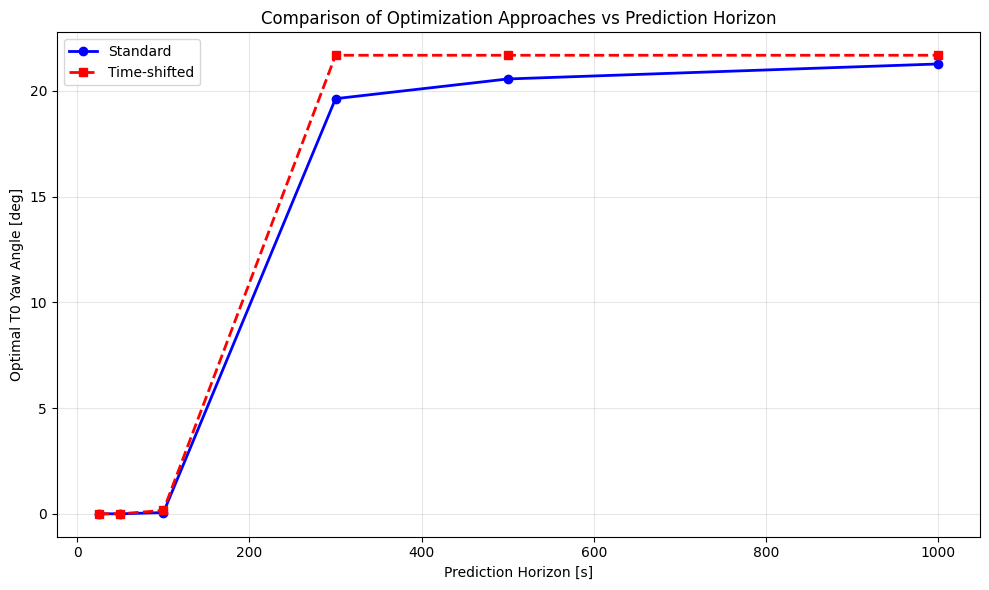

In [119]:
# Setup: T0 upstream, T1 downstream at 5D distance, 0.5D offset
D = 80.0
x_pos = [0.0, 10.0 * D]
y_pos = [0.0, 0.1 * D]

wt = V80()
model = WindFarmModel(x_pos, y_pos, wt, D=D, U_inf=8.0, TI=0.02, wd=270.0)

# Parameters from paper
r_gamma = 0.3  # deg/s
t_AH = 100.0   # s (allows ±30° change)
dt = 5.0       # s

# Test different prediction horizons
horizons = [25, 50, 100.0, 300.0, 500.0, 1000.0]
results = {'standard': [], 'shifted': []}

for T_pred in horizons:
    print(f"\nPrediction horizon: {T_pred}s")
    
    # Standard optimization
    opt_std = optimize_farm_back2front(
        model, np.zeros(2), r_gamma, t_AH, dt, T_pred,
        maxfun=1000, seed=42, use_time_shifted=False
    )
    
    # Time-shifted optimization  
    opt_shift = optimize_farm_back2front(
        model, np.zeros(2), r_gamma, t_AH, dt, T_pred,
        maxfun=1000, seed=42, use_time_shifted=True
    )
    
    # Calculate final yaw angles
    _, traj_std =   yaw_traj(0.0, opt_std[0, 0],   opt_std[0, 1], t_AH, r_gamma, dt, T_pred)
    _, traj_shift = yaw_traj(0.0, opt_shift[0, 0], opt_shift[0, 1], t_AH, r_gamma, dt, T_pred)
    
   
    idx_tAH = int(t_AH / dt)
    final_yaw_std = traj_std[min(idx_tAH, len(traj_std) - 1)]
    final_yaw_shift = traj_shift[min(idx_tAH, len(traj_shift) - 1)]


    results['standard'].append(final_yaw_std)
    results['shifted'].append(final_yaw_shift)
    
    print(f"  Standard approach: T0 yaw = {final_yaw_std:.1f}°")
    print(f"  Shifted approach:  T0 yaw = {final_yaw_shift:.1f}°")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(horizons, results['standard'], 'b-o', label='Standard', linewidth=2)
plt.plot(horizons, results['shifted'], 'r--s', label='Time-shifted', linewidth=2)
plt.xlabel('Prediction Horizon [s]')
plt.ylabel('Optimal T0 Yaw Angle [deg]')
plt.title('Comparison of Optimization Approaches vs Prediction Horizon')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [111]:
"""Verify that integration windows match paper's description."""
print("\n=== Test 2: Integration Window Verification ===")

# 3-turbine case with different spacings
D = 80.0
x_pos = [0.0, 5.0*D, 10.0*D]  # Aligned turbines
y_pos = [0.0, 0.0, 0.0]

wt = V80()
model = WindFarmModel(x_pos, y_pos, wt, D=D, U_inf=8.0, TI=0.054, wd=270.0)

# Calculate delays
print("\nDelay matrix (seconds):")
print(model.delays)
print(f"\nWith U_adv = {model.U_adv} m/s:")
print(f"T0 -> T1: {model.delays[0,1]:.1f}s")
print(f"T0 -> T2: {model.delays[0,2]:.1f}s") 
print(f"T1 -> T2: {model.delays[1,2]:.1f}s")

# Test time windows for shifted optimization
t_AH = 100.0
dt = 5.0

# Manually check what windows would be used
print(f"\nAction horizon: {t_AH}s")
print("\nIntegration windows for time-shifted cost:")

for i in range(3):
    print(f"\nOptimizing turbine T{i}:")
    print(f"  - T{i} power: [0, {t_AH}]s")
    
    for j in range(i+1, 3):
        delay = model.delays[i,j]
        start = delay
        end = delay + t_AH
        print(f"  - T{j} power: [{start:.0f}, {end:.0f}]s")


=== Test 2: Integration Window Verification ===

Delay matrix (seconds):
[[  0.  50. 100.]
 [  0.   0.  50.]
 [  0.   0.   0.]]

With U_adv = 8.0 m/s:
T0 -> T1: 50.0s
T0 -> T2: 100.0s
T1 -> T2: 50.0s

Action horizon: 100.0s

Integration windows for time-shifted cost:

Optimizing turbine T0:
  - T0 power: [0, 100.0]s
  - T1 power: [50, 150]s
  - T2 power: [100, 200]s

Optimizing turbine T1:
  - T1 power: [0, 100.0]s
  - T2 power: [50, 150]s

Optimizing turbine T2:
  - T2 power: [0, 100.0]s



=== Test 3: Detailed Optimization Behavior Comparison ===


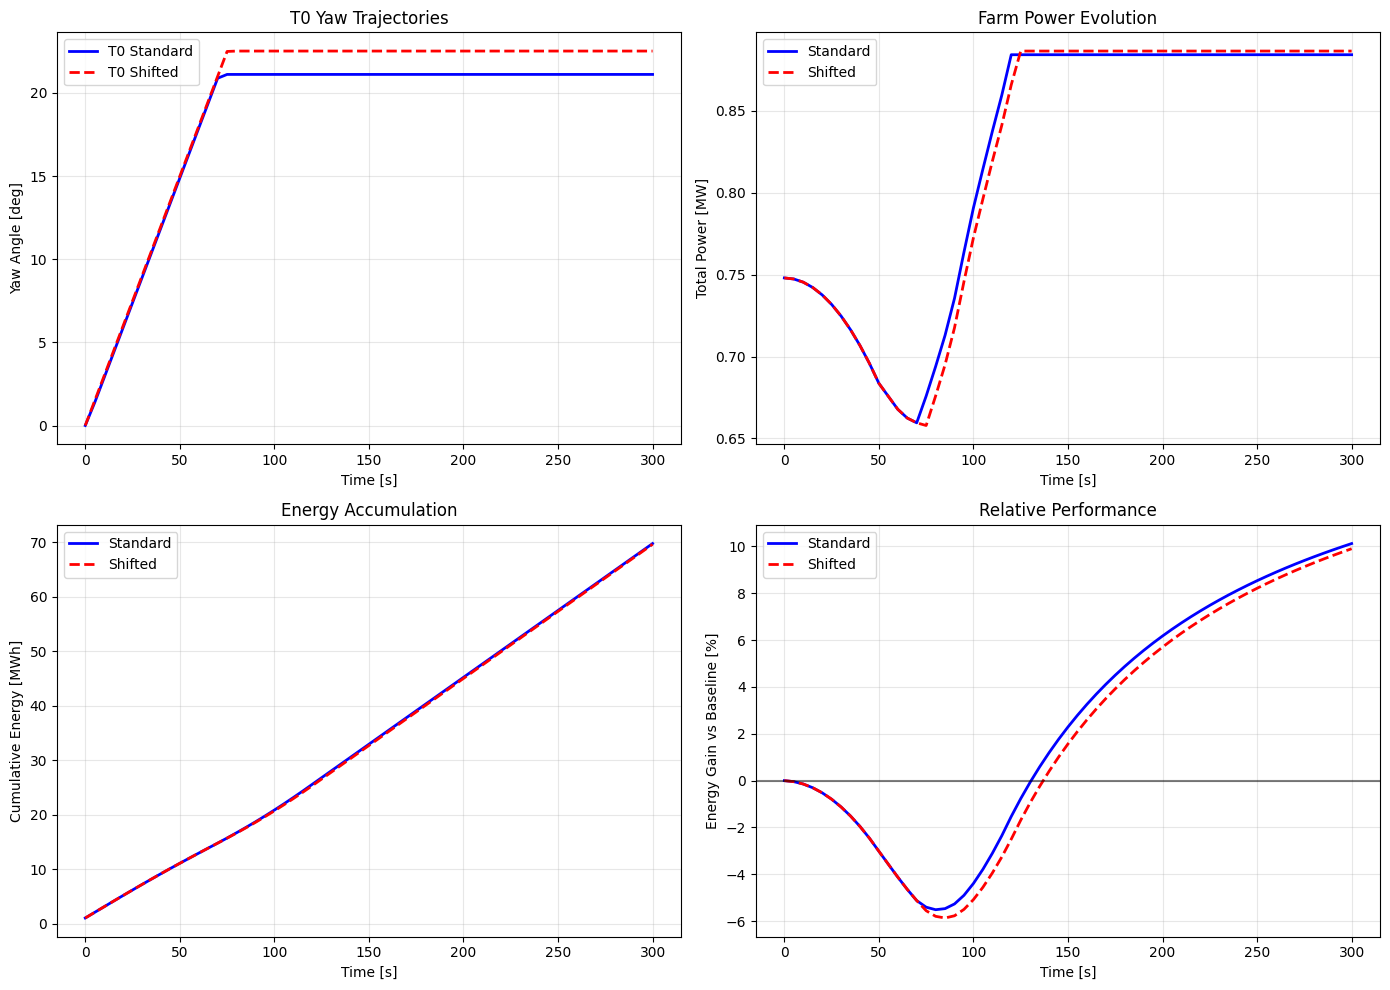


Final energy gain vs baseline:
  Standard:     10.12%
  Time-shifted: 9.90%

Optimal yaw angles at t=100.0s:
  Standard:     T0=21.1°, T1=0.1°
  Time-shifted: T0=22.5°, T1=1.6°


In [121]:
"""Compare standard vs time-shifted optimization in detail."""
print("\n=== Test 3: Detailed Optimization Behavior Comparison ===")

# 2-turbine setup
D = 80.0
x_pos = [0.0, 5.0 * D]
y_pos = [0.0, 0.1 * D]

wt = V80()
model = WindFarmModel(x_pos, y_pos, wt, D=D, U_inf=8.0, TI=0.054, wd=270.0)

r_gamma = 0.3
t_AH = 100.0
dt = 5.0
T_pred = 300.0  # Short horizon to see differences

# Get optimal parameters
opt_std = optimize_farm_back2front(
    model, np.zeros(2), r_gamma, t_AH, dt, T_pred,
    maxfun=3000, seed=42, use_time_shifted=False
)

opt_shift = optimize_farm_back2front(
    model, np.zeros(2), r_gamma, t_AH, dt, T_pred,
    maxfun=3000, seed=42, use_time_shifted=True
)

# Simulate both solutions
t_sim, traj_std, P_std = run_farm_delay_loop_optimized(
    model, opt_std, np.zeros(2), r_gamma, t_AH, dt, T_pred
)

_, traj_shift, P_shift = run_farm_delay_loop_optimized(
    model, opt_shift, np.zeros(2), r_gamma, t_AH, dt, T_pred
)

# Plot power and energy evolution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Yaw trajectories
ax = axes[0, 0]
ax.plot(t_sim, [traj_std[0][int(t/dt)] for t in t_sim], 'b-', label='T0 Standard', linewidth=2)
ax.plot(t_sim, [traj_shift[0][int(t/dt)] for t in t_sim], 'r--', label='T0 Shifted', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Yaw Angle [deg]')
ax.set_title('T0 Yaw Trajectories')
ax.legend()
ax.grid(True, alpha=0.3)

# Power evolution
ax = axes[0, 1]
ax.plot(t_sim, P_std.sum(axis=0)/1e6, 'b-', label='Standard', linewidth=2)
ax.plot(t_sim, P_shift.sum(axis=0)/1e6, 'r--', label='Shifted', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Total Power [MW]')
ax.set_title('Farm Power Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

# Cumulative energy
ax = axes[1, 0]
E_std_cum = np.cumsum(P_std.sum(axis=0)) * dt / 3600e3  # MWh
E_shift_cum = np.cumsum(P_shift.sum(axis=0)) * dt / 3600e3
ax.plot(t_sim, E_std_cum, 'b-', label='Standard', linewidth=2)
ax.plot(t_sim, E_shift_cum, 'r--', label='Shifted', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Cumulative Energy [MWh]')
ax.set_title('Energy Accumulation')
ax.legend()
ax.grid(True, alpha=0.3)

# Energy efficiency vs baseline
ax = axes[1, 1]
# Baseline (no yaw)
_, _, P_base = run_farm_delay_loop_optimized(
    model, [[0.5, 0.5], [0.5, 0.5]], np.zeros(2), r_gamma, t_AH, dt, T_pred
)
E_base_cum = np.cumsum(P_base.sum(axis=0)) * dt / 3600e3

eff_std = (E_std_cum / E_base_cum - 1) * 100
eff_shift = (E_shift_cum / E_base_cum - 1) * 100

ax.plot(t_sim, eff_std, 'b-', label='Standard', linewidth=2)
ax.plot(t_sim, eff_shift, 'r--', label='Shifted', linewidth=2)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Energy Gain vs Baseline [%]')
ax.set_title('Relative Performance')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nFinal energy gain vs baseline:")
print(f"  Standard:     {eff_std[-1]:.2f}%")
print(f"  Time-shifted: {eff_shift[-1]:.2f}%")

print(f"\nOptimal yaw angles at t={t_AH}s:")
print(f"  Standard:     T0={traj_std[0][int(t_AH/dt)]:.1f}°, T1={traj_std[1][int(t_AH/dt)]:.1f}°")
print(f"  Time-shifted: T0={traj_shift[0][int(t_AH/dt)]:.1f}°, T1={traj_shift[1][int(t_AH/dt)]:.1f}°")


In [114]:
"""Verify that back-to-front order produces different results than simultaneous."""
print("\n=== Test 4: Optimization Order Verification ===")

# 3-turbine case
D = 80.0
x_pos = [0.0, 5.0*D, 10.0*D]
y_pos = [0.0, 0.5*D, -0.5*D]

wt = V80()
model = WindFarmModel(x_pos, y_pos, wt, D=D, U_inf=8.0, TI=0.054, wd=270.0)

r_gamma = 0.3
t_AH = 100.0
dt = 5.0
T_pred = 500.0

# Back-to-front optimization
opt_b2f = optimize_farm_back2front(
    model, np.zeros(3), r_gamma, t_AH, dt, T_pred,
    maxfun=200, seed=42, use_time_shifted=True
)

# Simultaneous optimization (all at once)
def simultaneous_objective(x_flat):
    params = x_flat.reshape(3, 2)
    t, _, P = run_farm_delay_loop_optimized(
        model, params, np.zeros(3), r_gamma, t_AH, dt, T_pred
    )
    return -farm_energy(P, t)

from scipy.optimize import minimize
x0 = np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]).flatten()
bounds = [(0.0, 1.0)] * 6

res_sim = minimize(simultaneous_objective, x0, bounds=bounds, 
                    method='L-BFGS-B', options={'maxiter': 100})
opt_sim = res_sim.x.reshape(3, 2)

# Compare results
print("\nOptimization results (o1, o2 parameters):")
print("\nBack-to-front:")
for i in range(3):
    print(f"  T{i}: o1={opt_b2f[i,0]:.3f}, o2={opt_b2f[i,1]:.3f}")

print("\nSimultaneous:")
for i in range(3):
    print(f"  T{i}: o1={opt_sim[i,0]:.3f}, o2={opt_sim[i,1]:.3f}")

# Calculate energies
_, _, P_b2f = run_farm_delay_loop_optimized(
    model, opt_b2f, np.zeros(3), r_gamma, t_AH, dt, T_pred
)
_, _, P_sim = run_farm_delay_loop_optimized(
    model, opt_sim, np.zeros(3), r_gamma, t_AH, dt, T_pred
)

E_b2f = farm_energy(P_b2f, np.arange(0, T_pred+dt, dt))
E_sim = farm_energy(P_sim, np.arange(0, T_pred+dt, dt))

print(f"\nTotal energy:")
print(f"  Back-to-front:  {E_b2f/1e9:.3f} GWh")
print(f"  Simultaneous:   {E_sim/1e9:.3f} GWh")
print(f"  Difference:     {(E_b2f/E_sim - 1)*100:.2f}%")



=== Test 4: Optimization Order Verification ===

Optimization results (o1, o2 parameters):

Back-to-front:
  T0: o1=0.805, o2=0.043
  T1: o1=0.526, o2=0.998
  T2: o1=0.507, o2=0.991

Simultaneous:
  T0: o1=0.500, o2=0.500
  T1: o1=0.500, o2=0.500
  T2: o1=0.500, o2=0.500

Total energy:
  Back-to-front:  0.728 GWh
  Simultaneous:   0.682 GWh
  Difference:     6.78%
